In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# **Initializing objects:**

In [7]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  365
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')

Sat created


In [60]:
my_scanner = Scanner(double_telescope=True) 
print('Scanner created')

vega =    (279.2333, 38.78,  128.91,  201.03,   286.23, -13.9)
proxima = (217.42,  -62,     768.7,  3775.40,   769.33,  21.7)
sirio =   (101.28,  -16.716, 379.21, -546.05, -1223.14,  -7.6)


# sources
num_sources = 2
alphas     = np.random.rand(num_sources)*(279 - 101 )+101
deltas     = np.random.rand(num_sources)*(38  + 62  )-62
parallaxes = np.random.rand(num_sources)*(768 - 128 )+128
mu_alphas  = np.random.rand(num_sources)*(3775+ 546 )-546
mu_deltas  = np.random.rand(num_sources)*(769 + 1223)-1223
mu_radials = np.random.rand(num_sources)*(21  + 7   )-7

sources = []
for n in range(num_sources):
    sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Scanner created
Sources created


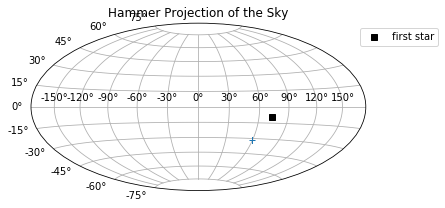

In [61]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []

for i, s in enumerate(sources):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')
        pass


plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

# **Scan**

In [62]:
1/24*3

0.125

In [69]:
obs_times = []
calc_sources = []
for s in sources:
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    obs_times.append(my_scanner.obs_times)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    print('Error: ', my_scanner.scanner_error())
    calc_sources.append(Calc_source(obs_times=my_scanner.obs_times, source=s))
    


Starting scan with time from 0 to 365 days
Total measured time: 7.8852458000183105
How many observation time?  10
Error:  -3.6193270602780105e-15
Starting scan with time from 0 to 365 days
Total measured time: 7.80962872505188
How many observation time?  7
Error:  -2.1046656481108326e-14


# **2- Combine with solver:**

In [70]:
def noise_calc_sources(s):
    noise = 0.02 / 10
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [71]:
for s in calc_sources:
    noise_calc_sources(s)
    print(len(s.obs_times))

7
7


In [73]:
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=True)

In [77]:
# Solver.reset_iterations()
Solver.iterate(10)

***** Iteration: 31 *****
Error after iteration: 9.211923732407408e-23
***** Iteration: 32 *****
Error after iteration: 3.048104280119694e-23
***** Iteration: 33 *****
Error after iteration: 9.600552457117505e-24
***** Iteration: 34 *****
Error after iteration: 2.8915033872717322e-24
***** Iteration: 35 *****
Error after iteration: 8.36970139484836e-25
***** Iteration: 36 *****
Error after iteration: 2.332597475865386e-25
***** Iteration: 37 *****
Error after iteration: 6.264762222795116e-26
***** Iteration: 38 *****
Error after iteration: 1.627176386882995e-26
***** Iteration: 39 *****
Error after iteration: 4.06009168262621e-27
***** Iteration: 40 *****
Error after iteration: 9.592507856391581e-28


In [78]:
gaia.wz

25.132741228718345

# **See iterations**

AttributeError: 'tuple' object has no attribute 'set_time'

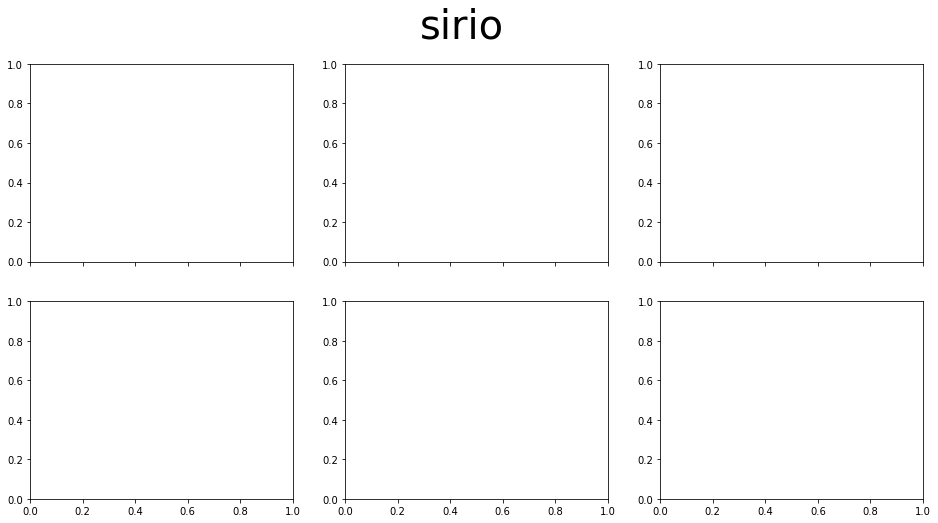

In [79]:
titles = ['sirio']
my_observations = scanSirio.obs_times
for source_index in range(len(Solver.calc_sources)):
    calc_source = Solver.calc_sources[source_index]
    real_source = Solver.real_sources[source_index]
    
    source_params = np.array(calc_source.s_old)
    fig, axs = plt.subplots(2, 3, figsize=(16,8), sharex='all')
    
    fig.suptitle(titles[source_index], fontsize=40)
    
    num_iters = len(calc_source.errors)
    labels = ['alpha', 'delta', 'parallax', 'mu_alpha', 'mu_delta']
    sirio.set_time(0)
    observed = [real_source.alpha, real_source.delta, real_source.parallax, real_source.mu_alpha_dx, real_source.mu_delta]

    alpha_list = []
    delta_list = []
    for t_L in my_observations:
        real_source.set_time(float(t_L))
        alpha_list.append(real_source.alpha)
        delta_list.append(real_source.delta)
    std_alpha = np.std(alpha_list)
    std_delta = np.std(delta_list)
    min_alpha, max_alpha = (np.min(alpha_list), np.max(alpha_list))
    min_delta, max_delta = (np.min(delta_list), np.max(delta_list))

    for i, x in enumerate(source_params.T):
        if i<3:
            ax = axs[0, i]
        else:
            ax = axs[1, i-3]
        ax.plot(x, 'b--.', label=labels[i])
        ax.hlines(observed[i], xmin=0, xmax=num_iters, color='g')
        ax.grid()
        ax.set_label('labels[i]')
        ax.set_xlabel('Iterations')
        ax.legend()

    axs[0,0].hlines(observed[0]+std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(observed[0]-std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(min_alpha, xmin=0, xmax=num_iters, color='r')
    axs[0,0].hlines(max_alpha, xmin=0, xmax=num_iters, color='r')

    axs[0,1].hlines(observed[1]+std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(observed[1]-std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(min_delta, xmin=0, xmax=num_iters, color='r')
    axs[0,1].hlines(max_delta, xmin=0, xmax=num_iters, color='r')

    # plot evolution of the error
    ax = axs[-1, -1] 
    ax.plot(calc_source.errors, 'b--.', label='objective function')
    # ax.set_xlim((0, num_iters))
    ax.set_xlabel('Iterations')
    ax.grid(alpha= 0.8)  
    ax.legend()


    fig.savefig('./figures/tmp/errors')

f3 = plt.figure()
plt.title('zoom on the error function')
plt.plot(calc_source.errors, 'b--.', label='objective function')
plt.ylim((0,0.9))
'running'